# Amortize NOvA model with Predictions & systematics

We will do this based on the model **predictions** this time, unlike in the previous notebook. This should give us far less overfitting.

Furthermore, I have added all NOvA systematics to the predictions: they are being sampled from a unit-gaussian, which is the prior used in our analyses.
Everything else is the same, however, apart from slightly simpler network being used.

At the end of the notebook I will create predictions for Asimov A, B and C, to be compared against our technote (the full comparison will not be in this repository).

This notebook will have far less explanation than the previous notebook, so do not read this one before reading the first notebook.

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


# Bayesflow for Amortized Bayesian Inference
import bayesflow as bf
from bayesflow.diagnostics import plots as bf_plots


# Internal helper functions
from load_data import get_data
from train_model import get_trained_model, train_model, get_approximator


2025-04-23 14:51:31.790124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-23 14:51:31.870903: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-23 14:51:31.896102: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-23 14:51:32.042392: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-23 14:51:33.097209: W tensorflow/compiler/tf2

# Generating Predictions

The predictions were generated offline using CAFAna.
The priors are the same as in the previous notebook, with an exception: all 2024 systematic parameters were used, which in this case were sampled from a gaussian prior `Gaussian(0,1)`

20M throws were made for this dataset.

# Loading & preparing the data for training

The same as before

In [2]:
# Get the first 10 data files
data_files = []
for data_file in glob.glob("../../synthetic_data_systs/synthetic_data_seed*.root"):
    data_files.append(data_file)

# Load the data
train, validate, test, spectra_norm, true_norm = get_data(data_files, 
                                                          validation_events=100_000,
                                                          testing_events=10_000)

loading 1/20: ../../synthetic_data_systs/synthetic_data_seed23_samples1000000.root
loading 2/20: ../../synthetic_data_systs/synthetic_data_seed11_samples1000000.root
loading 3/20: ../../synthetic_data_systs/synthetic_data_seed17_samples1000000.root
loading 4/20: ../../synthetic_data_systs/synthetic_data_seed29_samples1000000.root
loading 5/20: ../../synthetic_data_systs/synthetic_data_seed10_samples1000000.root
loading 6/20: ../../synthetic_data_systs/synthetic_data_seed20_samples1000000.root
loading 7/20: ../../synthetic_data_systs/synthetic_data_seed21_samples1000000.root
loading 8/20: ../../synthetic_data_systs/synthetic_data_seed16_samples1000000.root
loading 9/20: ../../synthetic_data_systs/synthetic_data_seed27_samples1000000.root
loading 10/20: ../../synthetic_data_systs/synthetic_data_seed14_samples1000000.root
loading 11/20: ../../synthetic_data_systs/synthetic_data_seed24_samples1000000.root
loading 12/20: ../../synthetic_data_systs/synthetic_data_seed15_samples1000000.root
l

In [3]:
print(f"Training shape for spectra train[0]: {train[0].shape}")
print(f"Training shape for parameters train[1]: {train[1].shape}")
print(f"Validation shape for spectra validate[0]: {validate[0].shape}")
print(f"Validation shape for parameters validate[1]: {validate[1].shape}")
print(f"Testing shape for spectra test[0]: {test[0].shape}")
print(f"Testing shape for parameters test[1]: {test[1].shape}")

print(f"Spectra normalization: {spectra_norm}")
print(f"True parameter normalization: {true_norm}")

# Put the data into format understood by BayesFlow & convert to float32 for
# better GPU performance
training_data= {
      "parameters": train[1].astype(np.float32),
      "observables": train[0].astype(np.float32)
}

validation_data = {
      "parameters": validate[1].astype(np.float32),
      "observables": validate[0].astype(np.float32)
}

testing_data = {
      "parameters": test[1].astype(np.float32),
      "observables": test[0].astype(np.float32)
}

# We will look at the first 5 events in the training more closely
testing_data_examples = {
      "parameters": test[1][:10].astype(np.float32),
      "observables": test[0][:10].astype(np.float32)
}

# Save the normalization values for later re-use
output_dir = "../checkpoints/simulated_test_10M_statsonly"
os.makedirs(output_dir, exist_ok=True)
np.savez(f"{output_dir}/normalization.npz", spectra_norm=spectra_norm, true_norm=true_norm)

Training shape for spectra train[0]: (19890000, 72, 1)
Training shape for parameters train[1]: (19890000, 5)
Validation shape for spectra validate[0]: (100000, 72, 1)
Validation shape for parameters validate[1]: (100000, 5)
Testing shape for spectra test[0]: (10000, 72, 1)
Testing shape for parameters test[1]: (10000, 5)
Spectra normalization: (8.014425149171739, 8.657147953981617)
True parameter normalization: (array([1.00009989, 0.08509946, 0.50001716, 2.50011745, 0.5000725 ]), array([0.57734903, 0.0020009 , 0.17322522, 0.28872744, 0.50000099]))


# Train the model

**Summary network**: The a simplified version of the `LSTM` network used before (fewer layers, fewer nodes per layer)

Batch size is 4084 for speed 5 epochs

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.
2025-04-23 14:55:11.127860: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1745416511.715415   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416511.773217   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416511.774154   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416511.778093   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416511.779032   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416511.779947   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416511.782695   15491 gpu_timer.cc:114] Skip

Epoch 1/5


W0000 00:00:1745416518.756620   15699 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416518.771627   15699 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416518.780736   15699 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416518.781722   15699 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416518.805738   15699 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416518.806359   15699 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416518.816209   15699 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416518.817233   15699 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416518.817837   15699 gp

   1/4856 ━━━━━━━━━━━━━━━━━━━━ 7:02:37 5s/step - loss: 8.6755 - loss/inference_loss: 8.6755

W0000 00:00:1745416519.653722   15699 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416519.662856   15699 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416519.664125   15699 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416519.664977   15699 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416519.666258   15699 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416519.667816   15699 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416519.669659   15699 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416519.670801   15699 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416519.672798   15699 gp

3918/4856 ━━━━━━━━━━━━━━━━━━━━ 1:31 98ms/step - loss: 1.1618 - loss/inference_loss: 1.1618

W0000 00:00:1745416903.924801   15698 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416903.925499   15698 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416903.926102   15698 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416903.926716   15698 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416903.927266   15698 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416903.927835   15698 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416903.932760   15698 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416903.933752   15698 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416903.934342   15698 gp

3920/4856 ━━━━━━━━━━━━━━━━━━━━ 1:31 98ms/step - loss: 1.1617 - loss/inference_loss: 1.1617

W0000 00:00:1745416904.141973   15692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416904.142602   15692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416904.143203   15692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416904.143809   15692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416904.144373   15692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416904.144966   15692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416904.145553   15692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416904.146470   15692 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416904.147353   15692 gp

4856/4856 ━━━━━━━━━━━━━━━━━━━━ 480s 98ms/step - loss: 1.1169 - loss/inference_loss: 1.1169 - val_loss: 0.9033 - val_loss/inference_loss: 0.9033
Epoch 2/5
   1/4856 ━━━━━━━━━━━━━━━━━━━━ 9:11 114ms/step - loss: 0.9265 - loss/inference_loss: 0.9265

W0000 00:00:1745416994.704211   15695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416994.704919   15695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416994.705550   15695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416994.706182   15695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416994.706820   15695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416994.707469   15695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416994.708152   15695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416994.708777   15695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745416994.709396   15695 gp

4856/4856 ━━━━━━━━━━━━━━━━━━━━ 469s 97ms/step - loss: 0.8842 - loss/inference_loss: 0.8842 - val_loss: 0.8358 - val_loss/inference_loss: 0.8358
Epoch 3/5
4856/4856 ━━━━━━━━━━━━━━━━━━━━ 482s 99ms/step - loss: 0.8499 - loss/inference_loss: 0.8499 - val_loss: 0.8508 - val_loss/inference_loss: 0.8508
Epoch 4/5
4856/4856 ━━━━━━━━━━━━━━━━━━━━ 484s 100ms/step - loss: 0.8333 - loss/inference_loss: 0.8333 - val_loss: 0.8168 - val_loss/inference_loss: 0.8168
Epoch 5/5
4856/4856 ━━━━━━━━━━━━━━━━━━━━ 486s 100ms/step - loss: 0.8238 - loss/inference_loss: 0.8238 - val_loss: 0.8442 - val_loss/inference_loss: 0.8442


Model: "continuous_approximator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flow_matching (FlowMatching)    │ ?                      │       284,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_series_network             │ ?                      │       136,928 │
│ (TimeSeriesNetwork)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,263,281 (4.82 MB)

 Trainable params: 421,093 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 842,188 (3.21 MB)

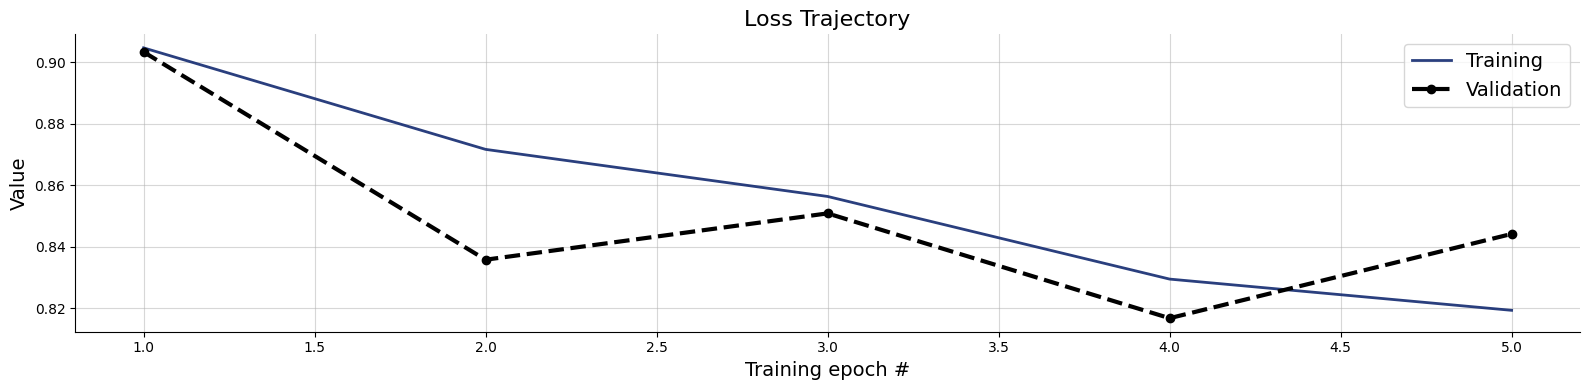

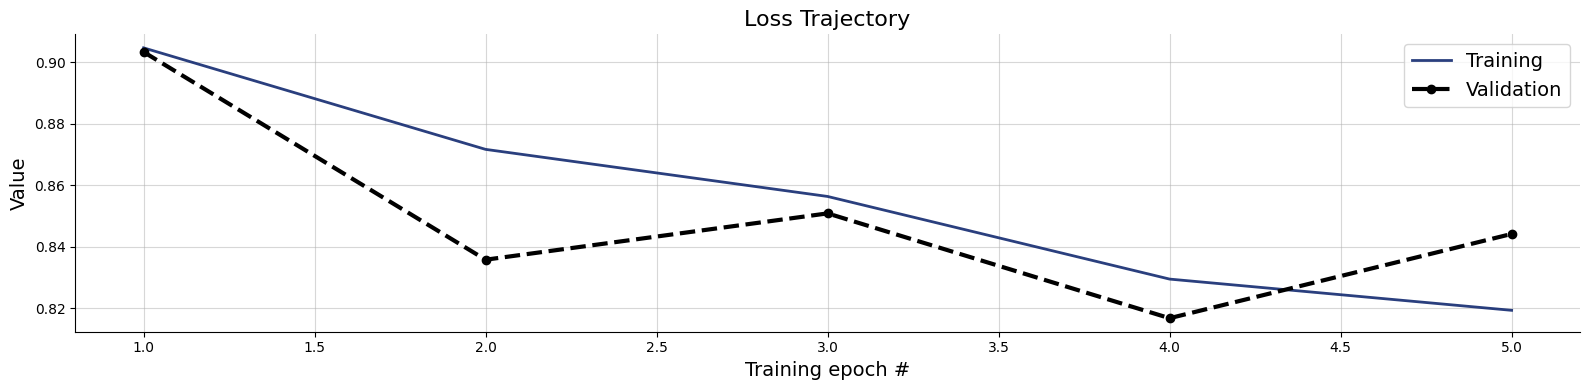

In [4]:
# Get the model
approximator = get_approximator(summary_network_type="time_series_simple")

# Train the model, this will take a while...
history = train_model(approximator, 
                      training_data=training_data, 
                      validation_data=validation_data,
                      epochs=5)

# Print the network summary.
# TODO: build the model prior to training & put the summary there.
approximator.summary()

# Save the model
approximator.save(f"{output_dir}/approximator.keras")

# Plot the loss history!
# TODO: Evaluate the model before training & prepend to the history prior to plotting
bf_plots.loss(history)

# Get all the diagnostics

We will get diagnostics as before

In [5]:

# Sample 500 posterior samples from the model for all the testing datasets
test_posterior = approximator.sample(conditions=testing_data, num_samples=100)

W0000 00:00:1745418916.378939   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745418916.380510   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745418916.381893   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745418916.383258   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745418916.384706   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745418916.386187   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745418916.387852   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745418916.389217   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745418916.390580   15491 gp

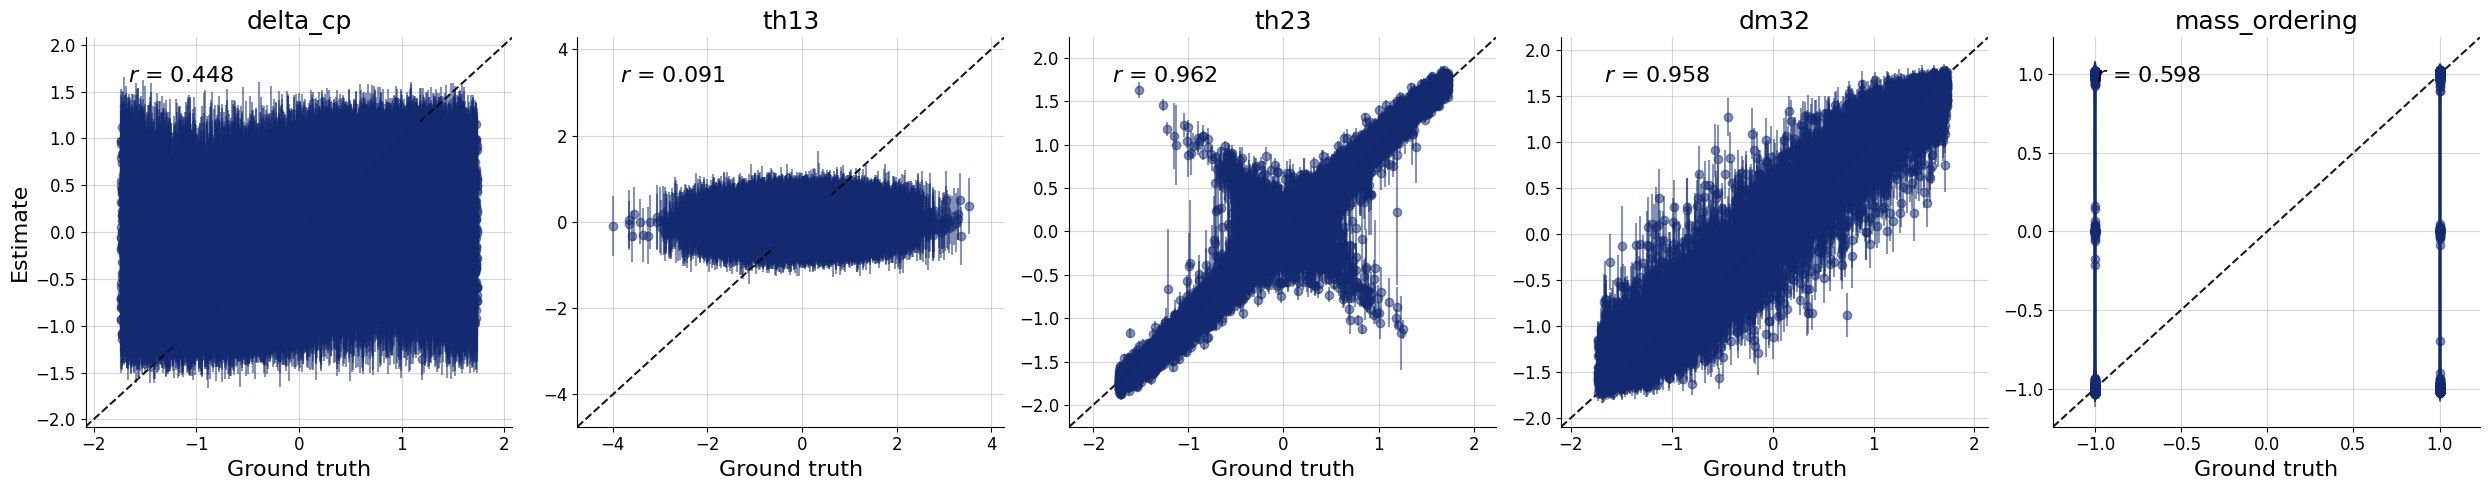

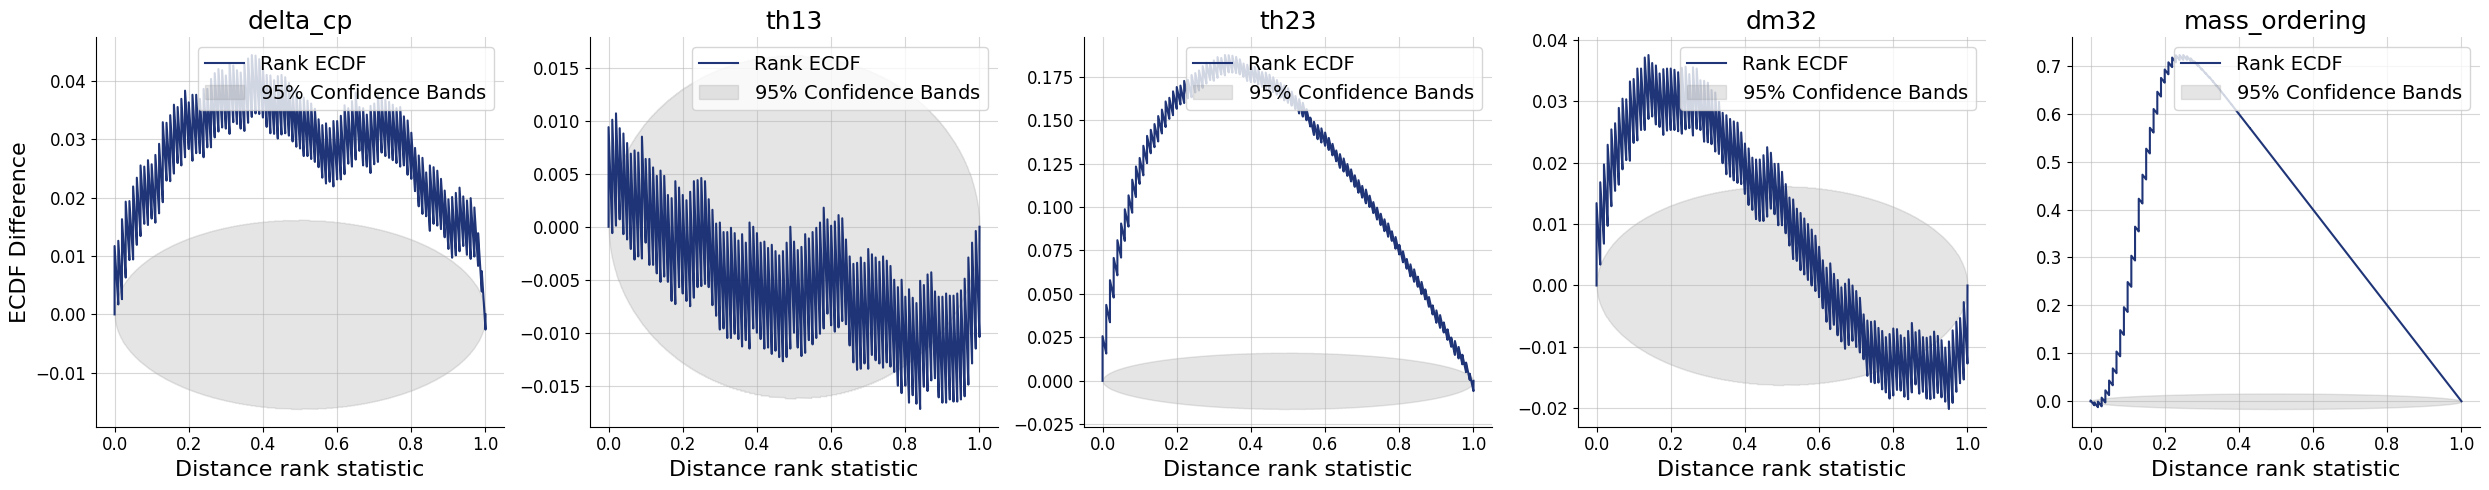

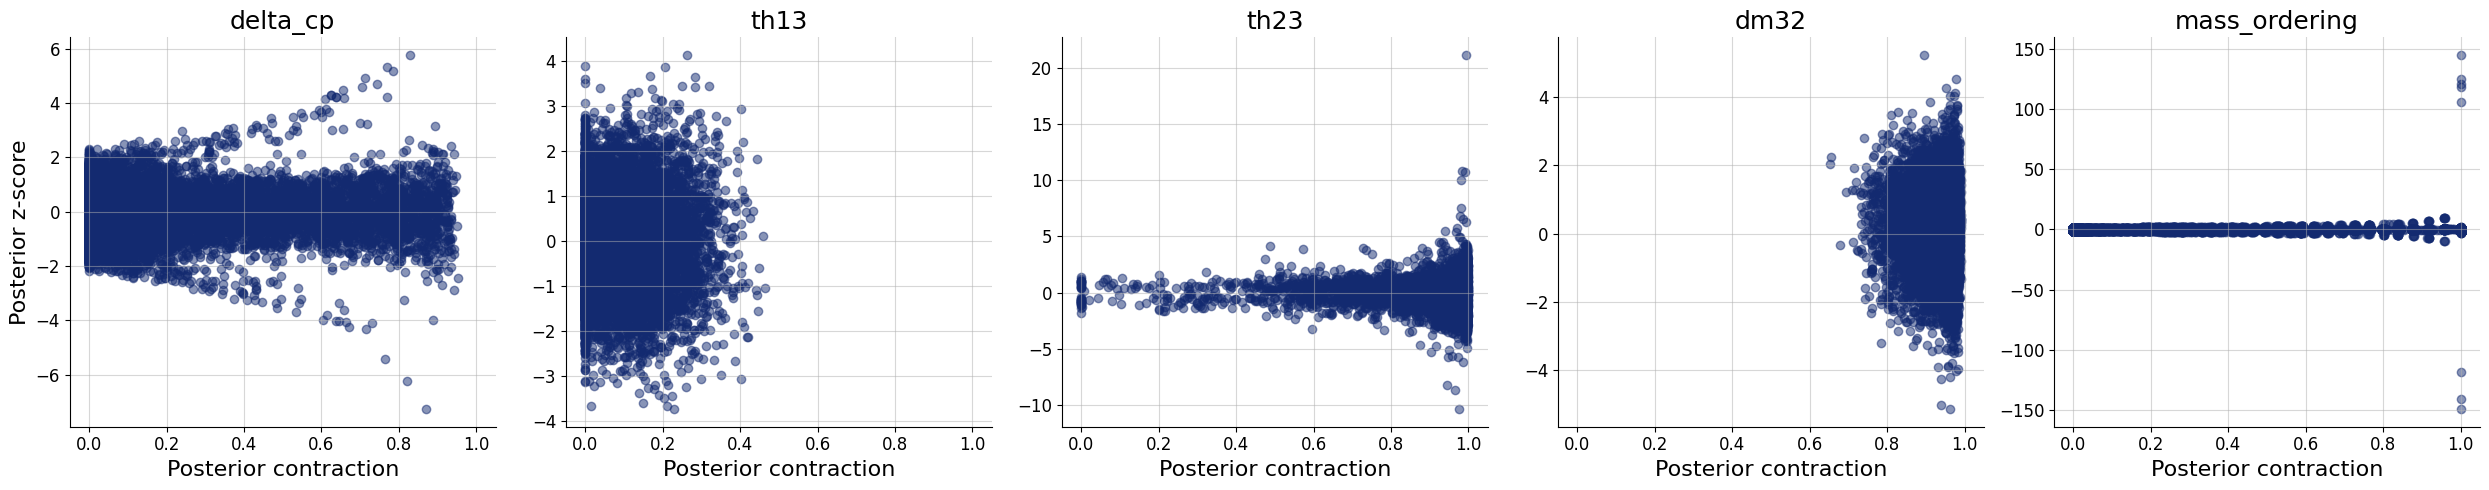

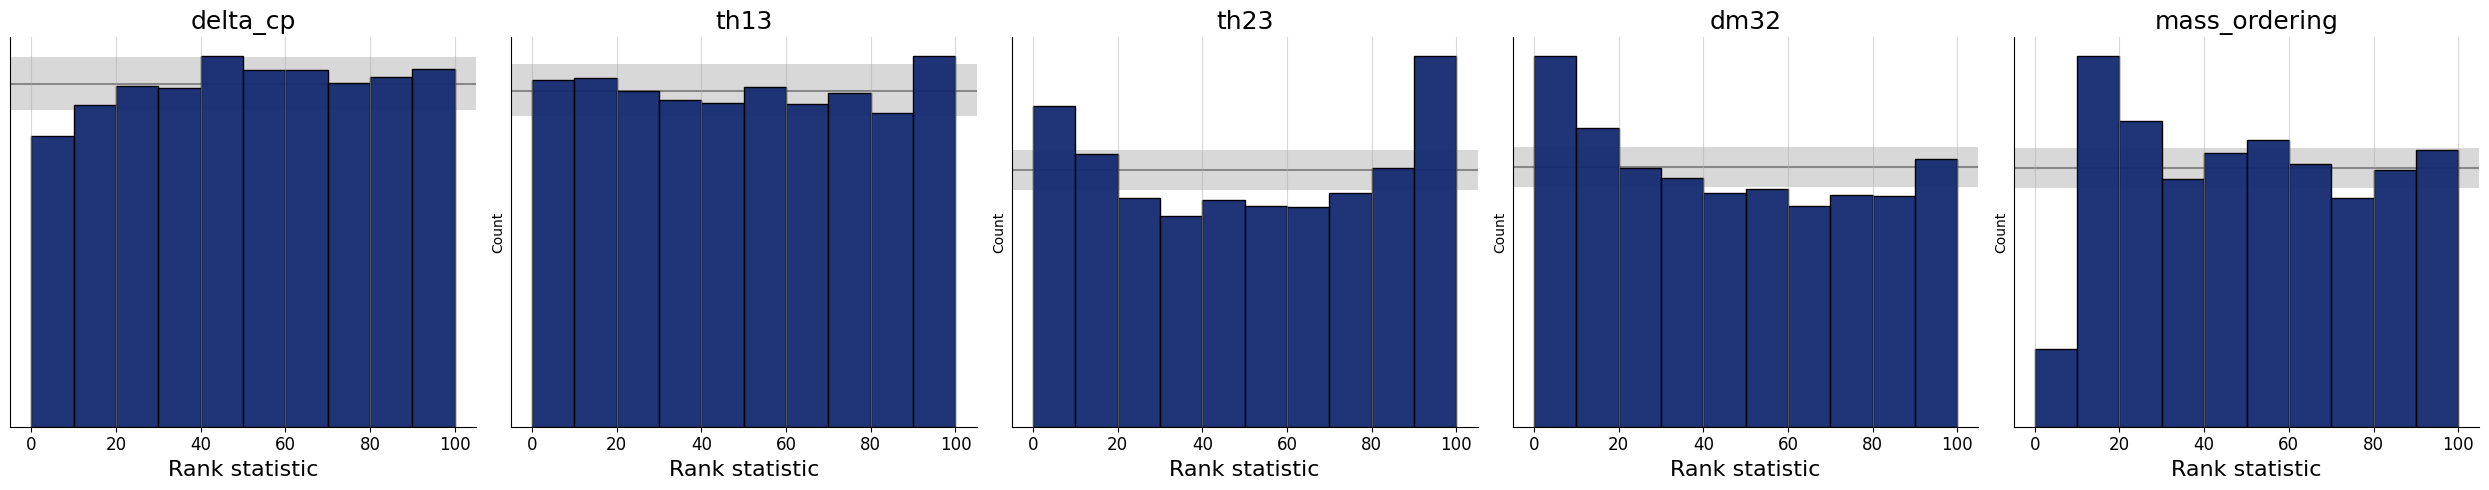

In [6]:
# Parameter names for plotting
variable_names = ["delta_cp", "th13", "th23", "dm32", "mass_ordering"]

# Plots to generate
plot_fns = {
  "recovery": bf_plots.recovery,
  "calibration_ecdf": bf_plots.calibration_ecdf,
  "z_score_contraction": bf_plots.z_score_contraction,
  "calibration_histogram": bf_plots.calibration_histogram
}

# Generate the plots
for k, plot_fn in plot_fns.items():
  if  k == "calibration_ecdf":
      plot_fn(
          estimates=test_posterior,
          targets=testing_data,
          variable_names=variable_names,
          difference=True,
          rank_type="distance"
      )
  else:
      plot_fn(
          estimates=test_posterior,
          targets=testing_data,
          variable_names=variable_names
      )

# Diagnostics interpretation

This is already far better than the previous tests with the emulated datasets, but with a few issues nevertheless:
1. For `delta_cp`, the model is slightly under & over estimating on some fraction of the validation samples. This could be somewhat expected due to the combinations of the parameter being degenerate, and the validation samples being poisson-fluctuated, so it should be easy to get the "wrong mode". Furthermore, only used 100 samples.
2. `theta13` looks mostly very good! There are clearly ver few low estimates, but that's it.
3. `theta23` Model slightly over-estimating and a bit too certain.
4. `dm32`: Model a bit too certain and could be over-estimating at times.
4. `mass_ordering`: same as before

Switching from expectations to predictions clearly helped a lot, as expected. However, clearly more could be done to improve the posterior approximations! Now the plan is:
1. Increase the amount of data by an order of magnitude (will need to use DiskDataset class for that)
2. Play with the dropout rate & network structure (simplifying further), but lets se how 1. works out first

# Examining few posteriors

We will now sample posteriors for 5 datasets and create triangle plots for each one of them, marking the true input parameter values on the 1D histograms.


In [7]:
# Generate 10,000 posterior samples for the first 5 events in the testing dataset
test_posterior = approximator.sample(conditions=testing_data_examples, num_samples=5_000)

W0000 00:00:1745418953.748246   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745418953.748870   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745418953.749381   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745418953.749895   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745418953.750395   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745418953.750899   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745418953.751394   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745418953.751892   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745418953.752398   15491 gp

In [8]:
# Convert the posterior samples back to the original parameter space
std = true_norm[1]
mean = true_norm[0]
test_posterior['parameters'] = test_posterior['parameters'] * std[None, None, :] + mean[None, None, :]
testing_data_examples['parameters'] = testing_data_examples['parameters'] * std[None, :] + mean[None, :]

Plotting posterior pairs for testing fake data sample 0


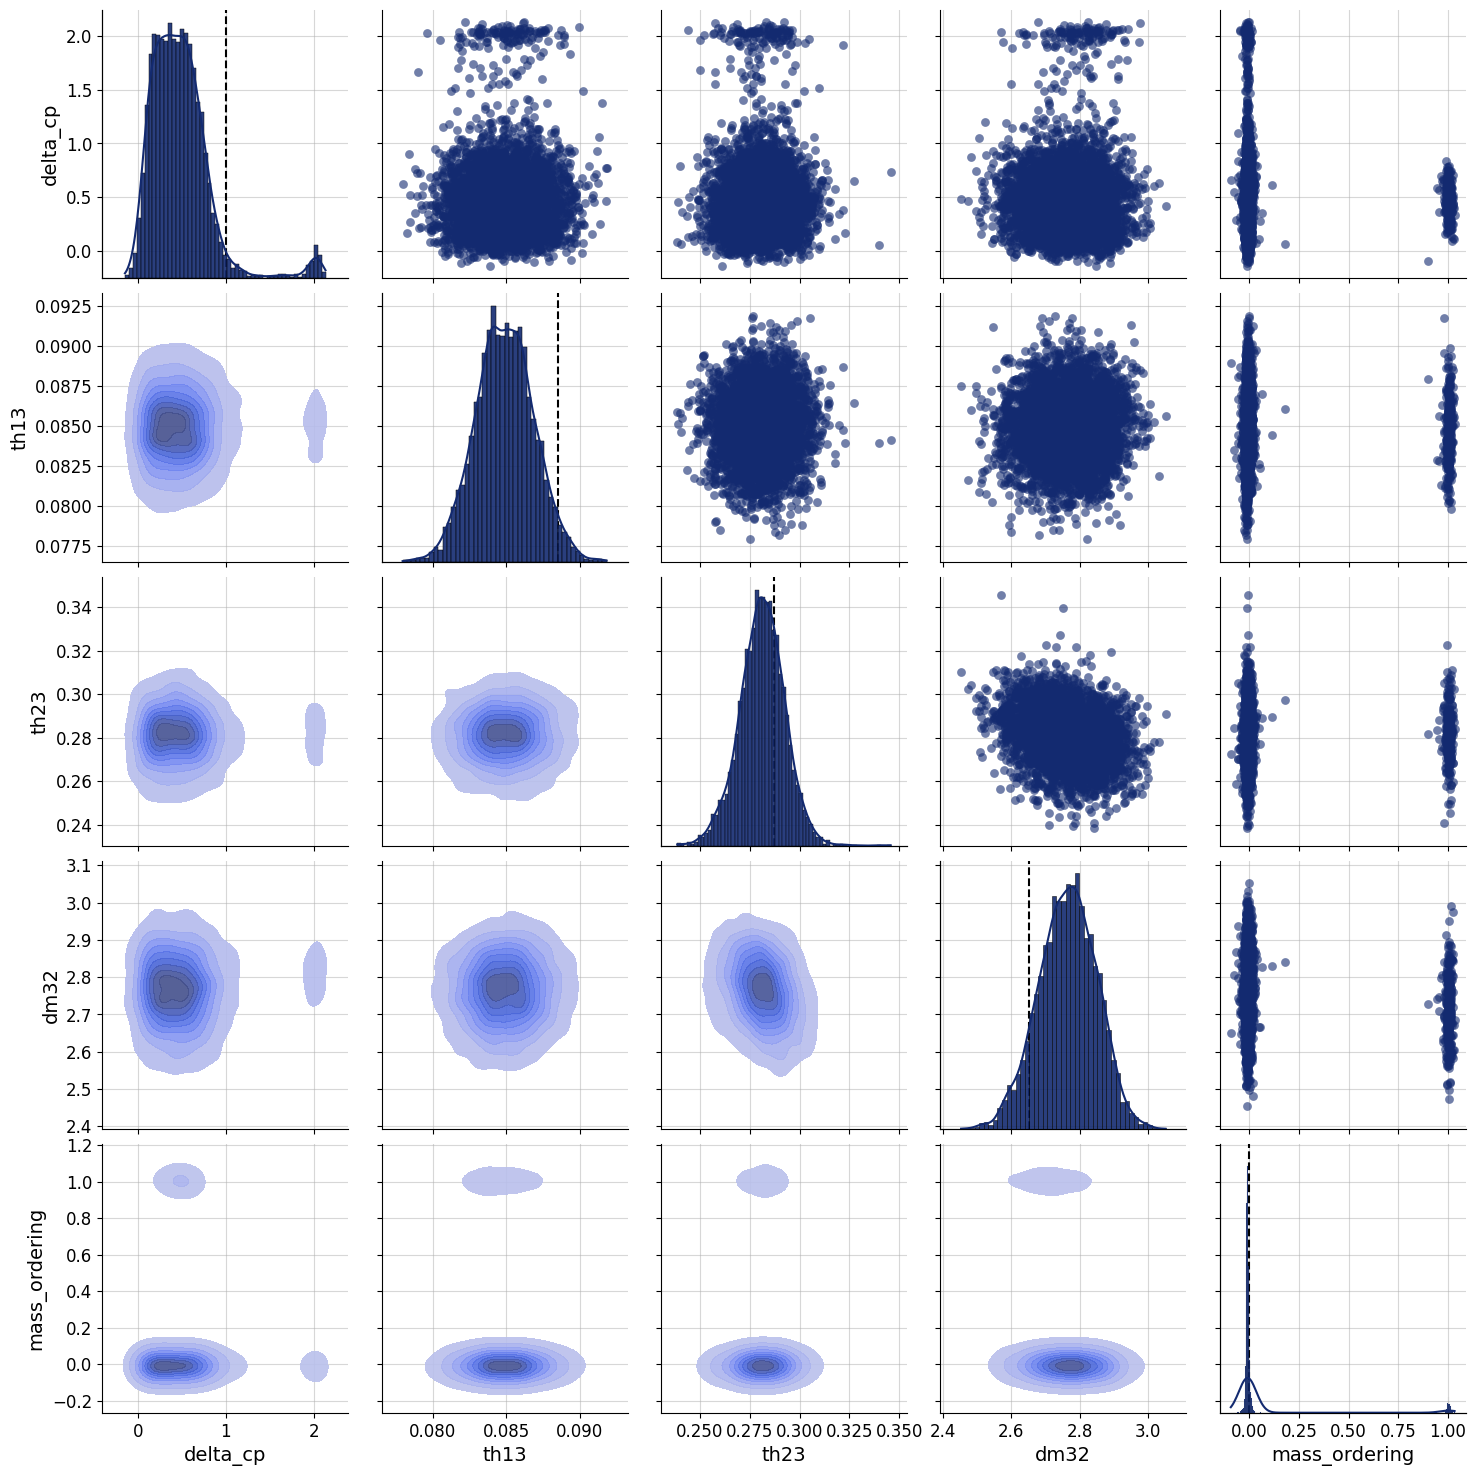

Plotting posterior pairs for testing fake data sample 1


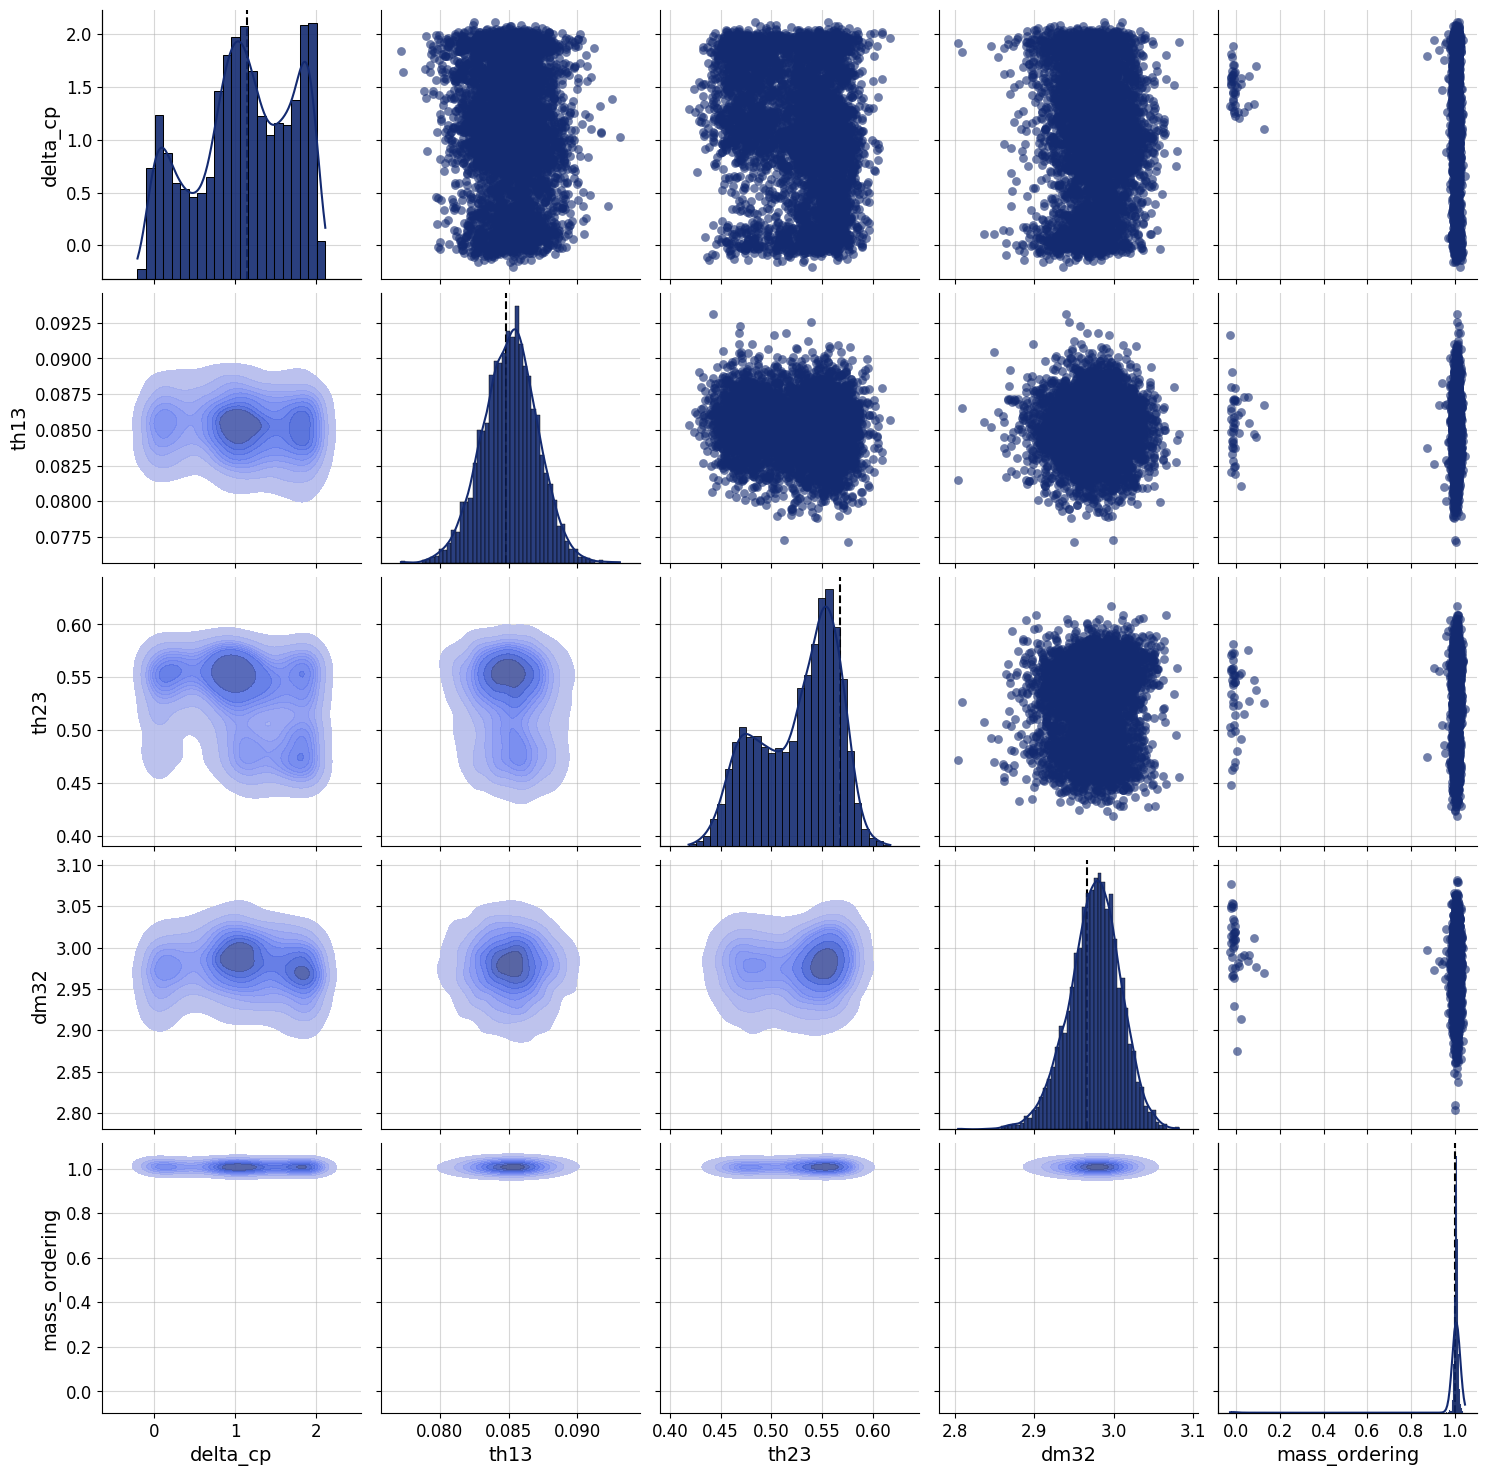

Plotting posterior pairs for testing fake data sample 2


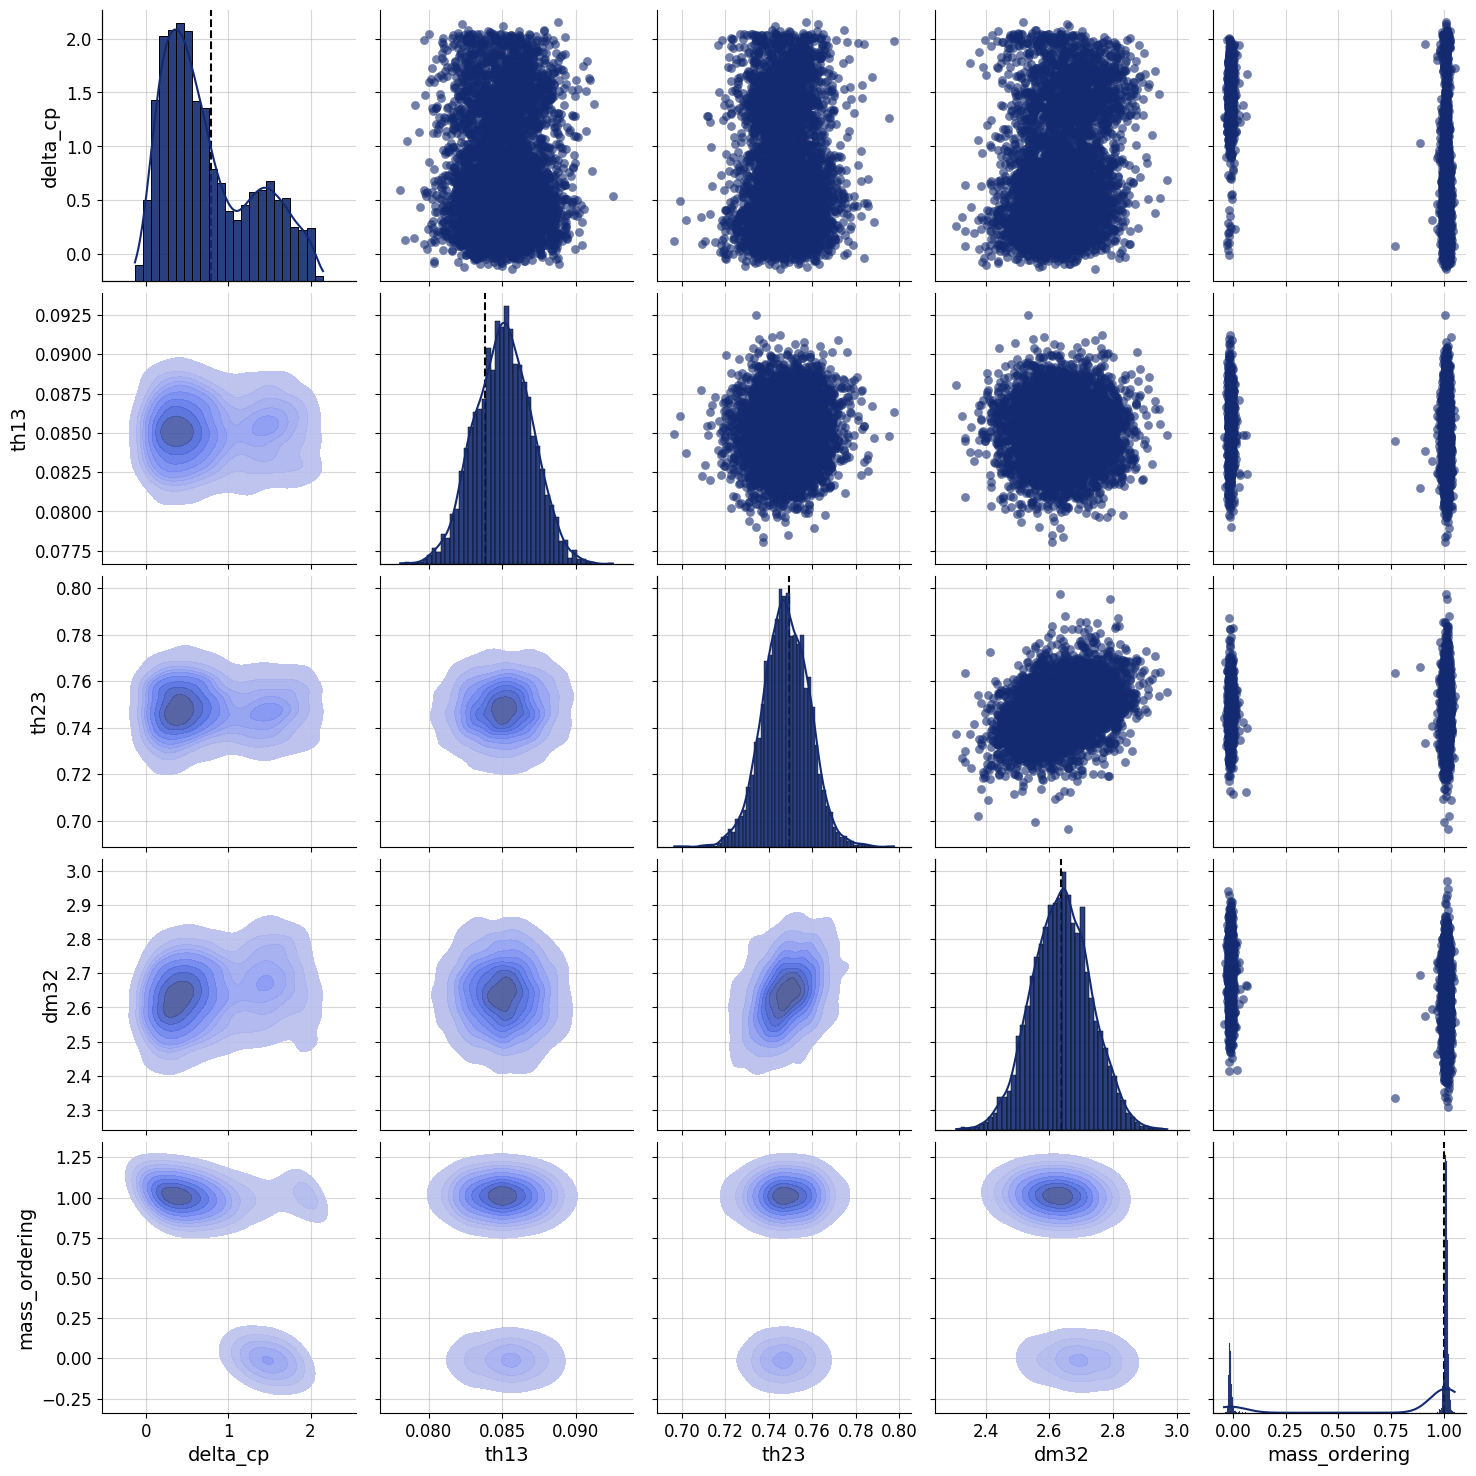

Plotting posterior pairs for testing fake data sample 3


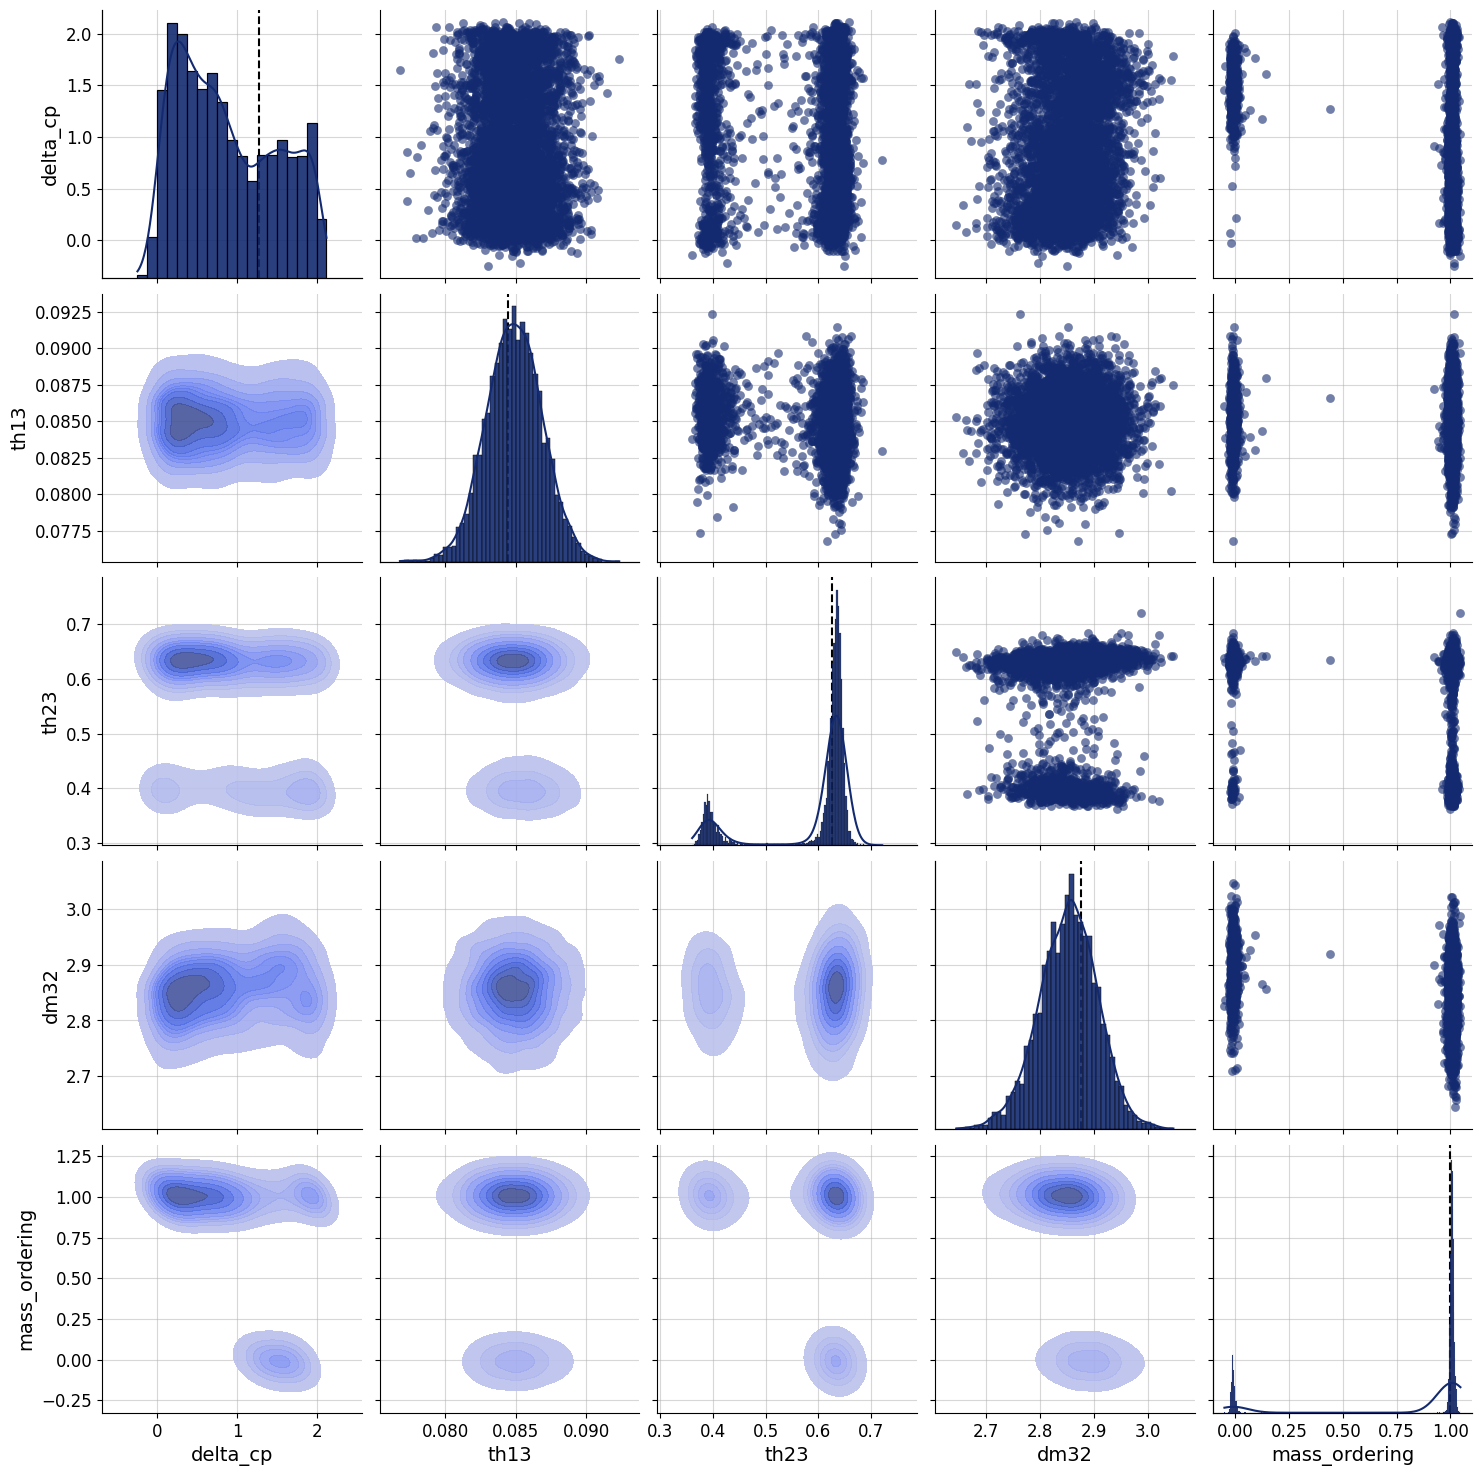

Plotting posterior pairs for testing fake data sample 4


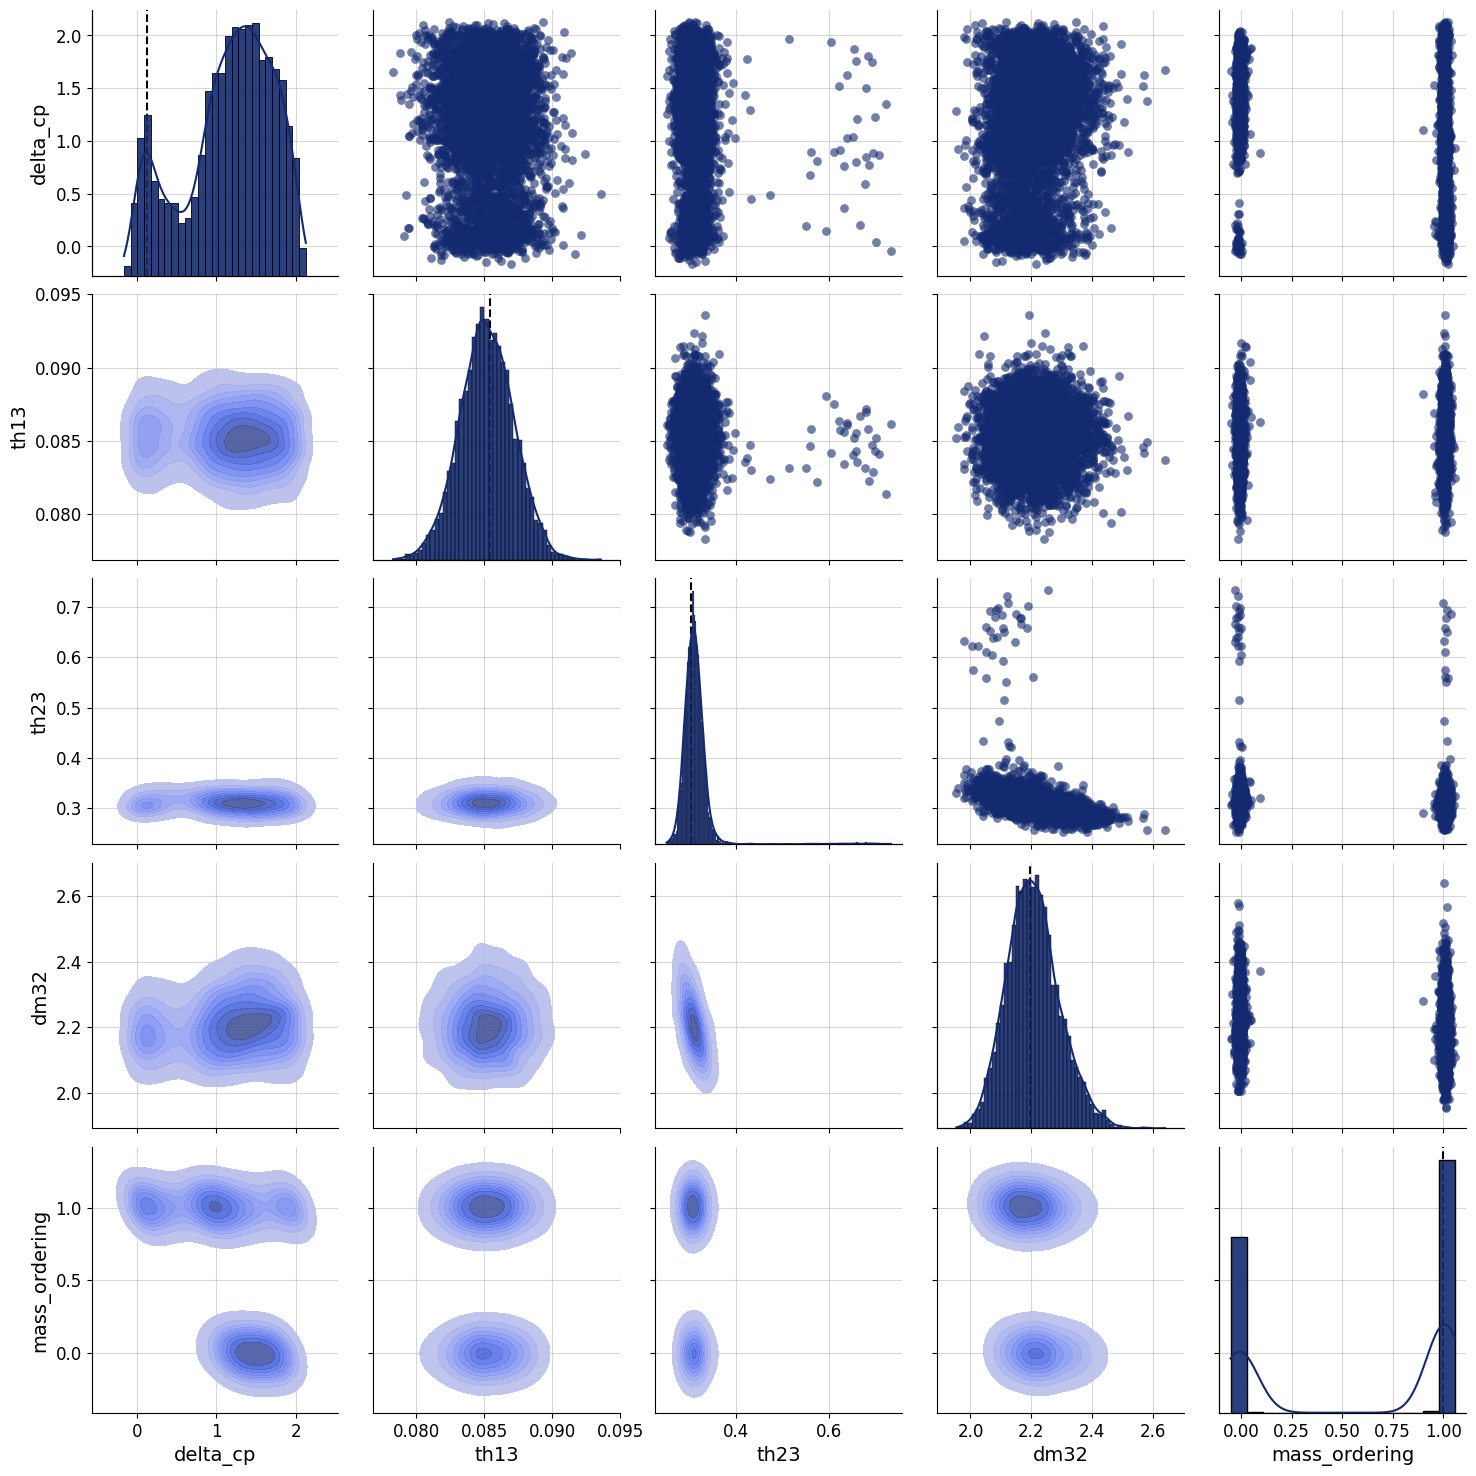

In [9]:
for n in range(5):
    print(f"Plotting posterior pairs for testing fake data sample {n}")
    bf_plots.pairs_posterior(
        estimates=test_posterior, 
        targets=testing_data_examples,
        dataset_id=n,
        variable_names=variable_names
    )
    plt.show()

# Examining the examples
The input vs posterior comparisons are far, far better this time. We see `delta_cp` often not being constrained well, `dm32` having different central values between NO & IO, etc.

It is difficult to tell about `theta23` here: the input values are always quite far from 0.5, which changes the oscillation probability a lot: and it's difficult to know what to expect here. The only example with `th23` being close to 0.5 (sample 1), however, looks very reasonable!

Before making further conclusions, lets generate posteriors for some well-understood data. We will use Asimov A, B and C inputs to generate "expectation" spectra and see what the ABI-sampled posterior looks like.

I will not make full MCMC vs ABI comparisons here, that might be put in a private repository instead...


# Asimov data

Since this these "approximate" posteriors with ABI, the posteriors should be not identical, but at least "similar" to the asimov posteriors retrieved in 2024/2025 analysis with MCMC techniques.

In [10]:
asimov_datafile = ["../../dev/asimov_data.root"]
asimov_data, _, _, _, _= get_data(asimov_datafile,
                                   spectra_norm=spectra_norm,
                                   true_norm=true_norm,
                                   validation_events=0,
                                   testing_events=0)
asimov_data = {
    "parameters": asimov_data[1].astype(np.float32),
    "observables": asimov_data[0].astype(np.float32)
}

loading 1/1: ../../dev/asimov_data.root


In [11]:
posterior_asimov = approximator.sample(conditions=asimov_data, num_samples=10_000)

W0000 00:00:1745419062.062712   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745419062.063330   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745419062.063835   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745419062.064338   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745419062.064841   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745419062.065346   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745419062.065847   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745419062.066349   15491 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745419062.066853   15491 gp

Plotting posterior pairs for Asimov A


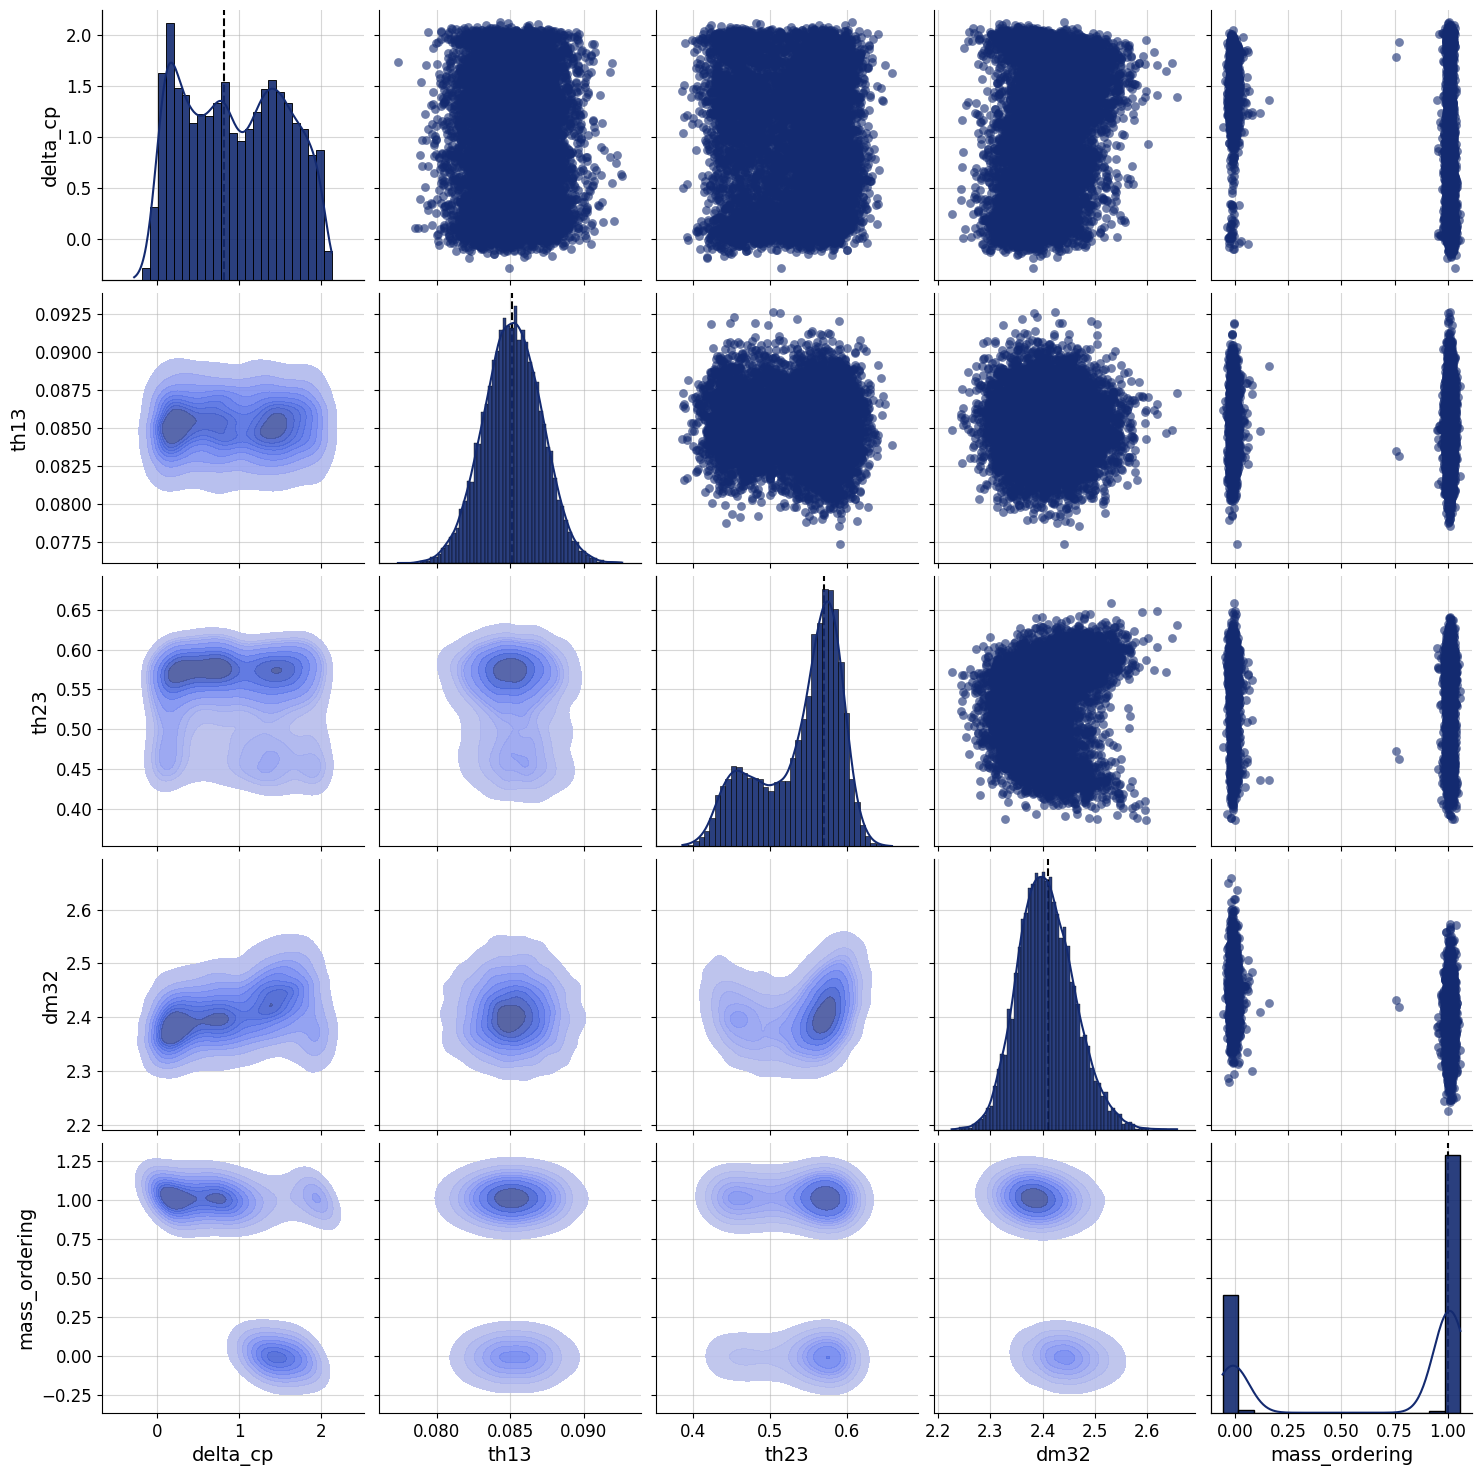

Plotting posterior pairs for Asimov B


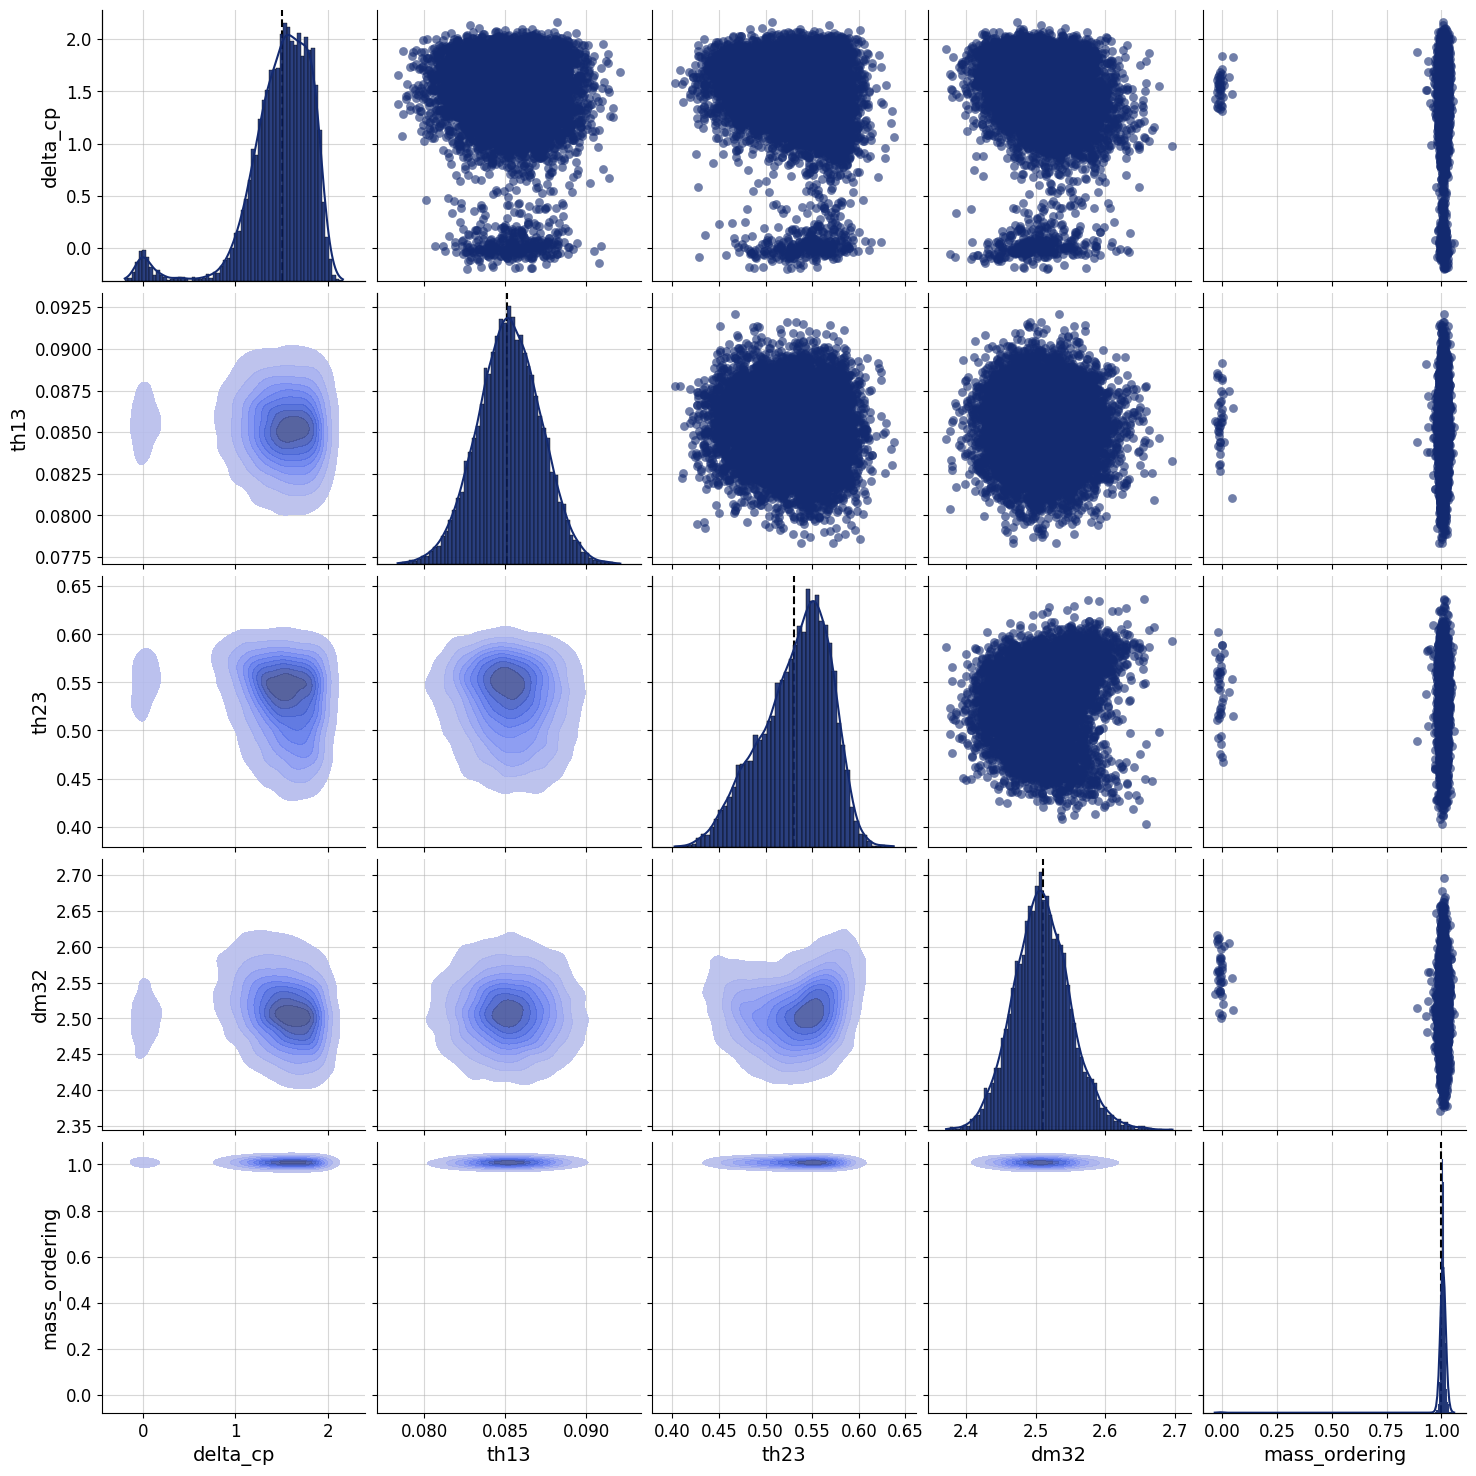

Plotting posterior pairs for Asimov C


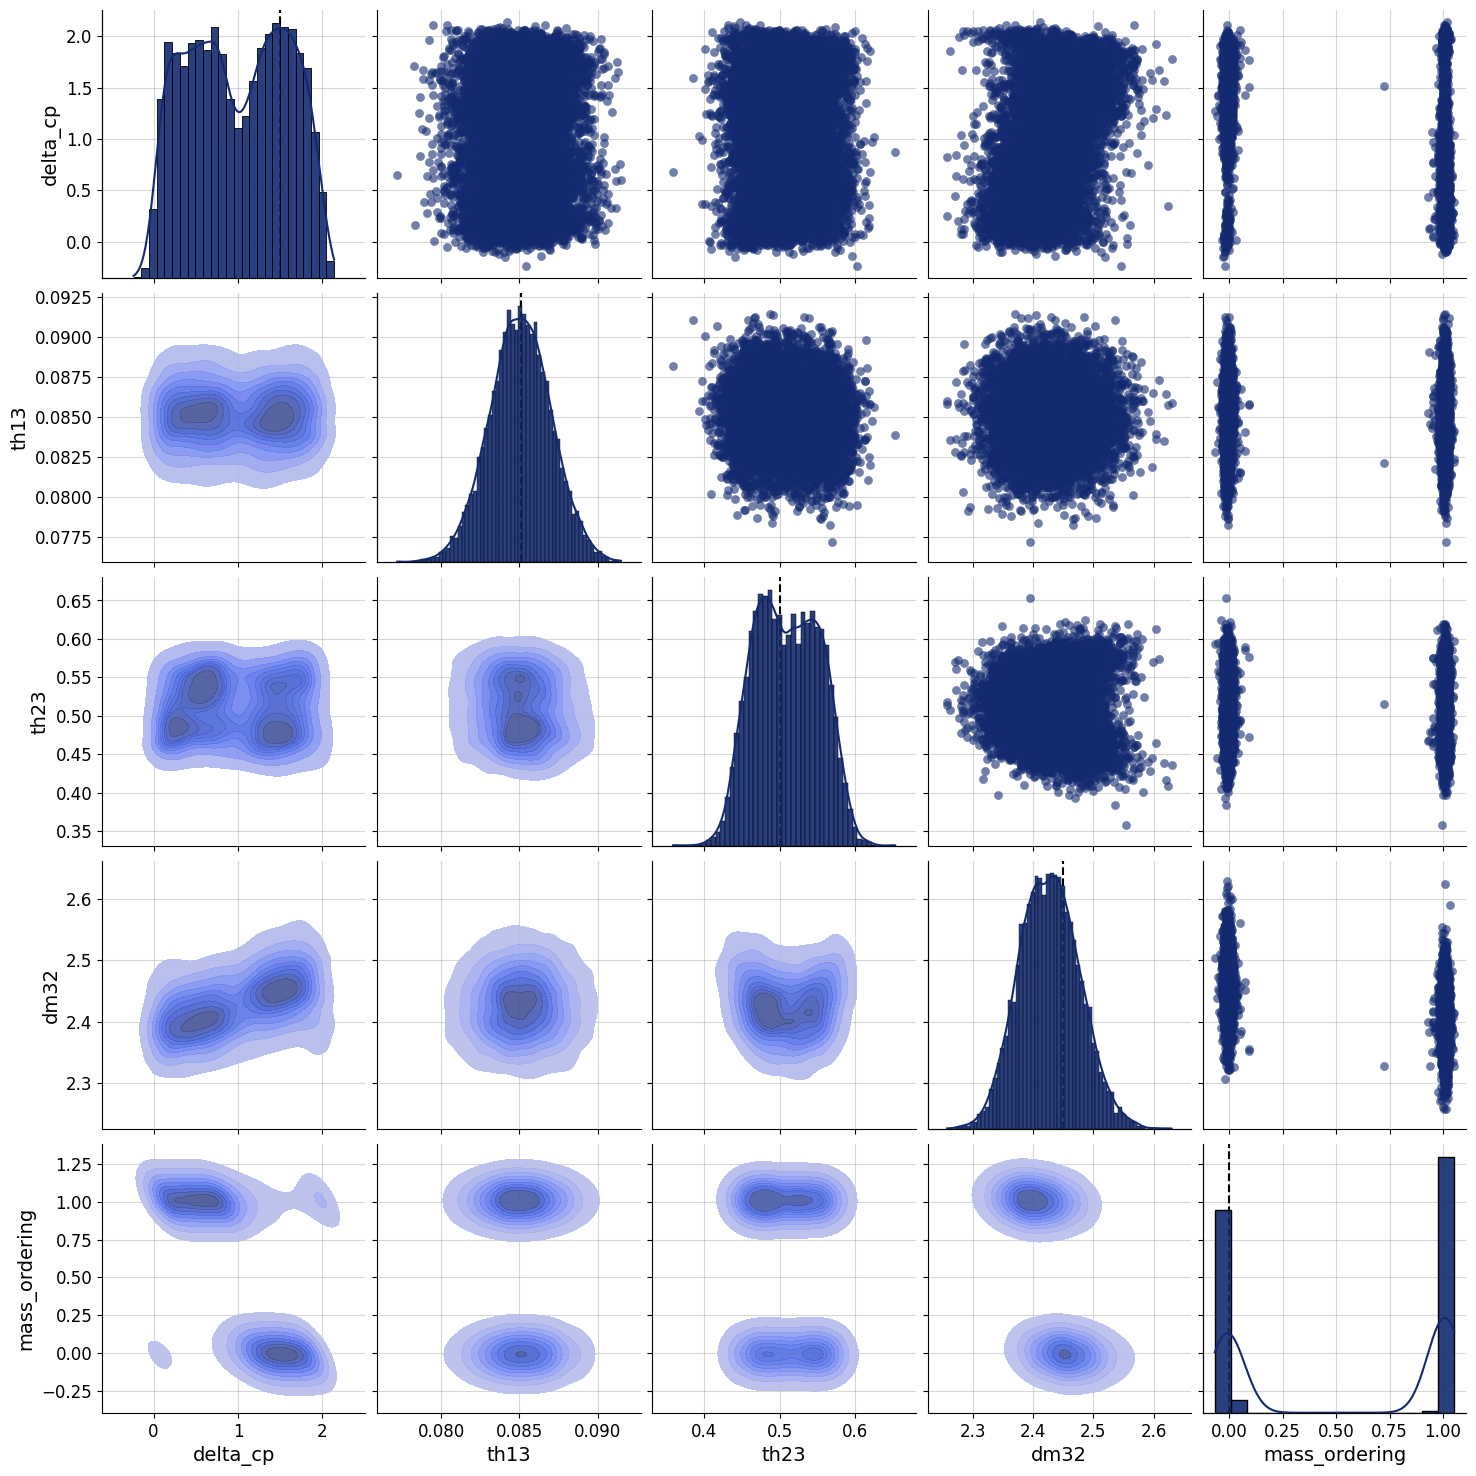

In [12]:
posterior_asimov['parameters'] = posterior_asimov['parameters'] * std[None, None, :] + mean[None, None, :]
asimov_data['parameters'] = asimov_data['parameters'] * std[None, :] + mean[None, :]

asimov_points = ["A", "B", "C"]
dataset_id=0
for n in range(3):
    print(f"Plotting posterior pairs for Asimov {asimov_points[n]}")
    g = bf_plots.pairs_posterior(
        estimates=posterior_asimov, 
        targets=asimov_data,
        dataset_id=n,
        variable_names=["delta_cp", "th13", "th23", "dm32", "mass_ordering"],
    )
    plt.show()

# Conclusions

The posteriors for Asimov A, B and C look very reasonable, and very comparable to *docid-62090-v8*! The posteriors, even in 2D, look very comparable, and I am especially happy to see the high-posterior density areas for `delta_cp` matching the technote very well. 
My only concern is Asimov C, where the IO preference was not retrieved, as it was with MCMC.
Of course, full comparisons should be made, with `delta_cp` being looped between 0-2pi, 1,2,3 sigma contours extracted, and compared on the same plots with MCMC-extracted contours.

Overall conclusions for now are:
1. ABI clearly did manage to approximate posteriors well, despite evidence of overfitting.
2. More data should be used in training, and network architecture revisited to resolve the issues with overfitting.
3. ABI looks like a viable way of making many rapid posterior predictions for NOvA, with various datasets.

Next step, apart from looking into overfitting, are:
1. Include POT as a "data condition" variable
2. Look into "future sensitivity studies" for various POTs, FHC/RHC fractions and input values of `delta_cp`.